# Code setup

In [71]:
try:
    %load_ext lab_black
except ModuleNotFoundError:
    print("Couldn't load Black autoformatter.")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [72]:
# To suppress warning output
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys
import math

# Set random seed across notebook for repeatable results
np.random.seed(1922)  # for Papa

In [75]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.titlesize"] = "x-large"  # 16
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "x-large"

In [76]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)):
    print("Figure directory did not exist, creating now.")
    os.mkdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)
else:
    print("Figure directory exists.")

Figure directory exists.


In [77]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt

importlib.reload(blt)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.


<module 'functions' from '/Users/blt/Documents/ml-weight-fraction/functions.py'>

# Data

In [78]:
# Source (bulk organics) data

# Read in organics CP feature data
X = pd.read_csv(
    "./data/organics-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)
# Read in organics CP labels (maximum_weight_fraction)
y = pd.read_csv(
    "./data/organics-preprocessed-WF.csv", sep="\t", header="infer", index_col=0
)
y.index = X.index
print("X shape:", X.shape)
print("y shape:", y.shape)

# Read in previous hyperparameterization results
results_prelim = pd.read_csv(
    "./data/results-prelim-organics.csv", sep="\t", na_values="nan"
)

X shape: (16439, 53)
y shape: (16439, 1)


## Apply WF bins

Labels (continuous WF data) will be binned into low (0.00-0.01), medium (0.01-0.10) and high (0.10-1.00) categories.

In [79]:
# Apply bins to organics data
ybin = np.asarray(y.apply(blt.bins, axis=1))

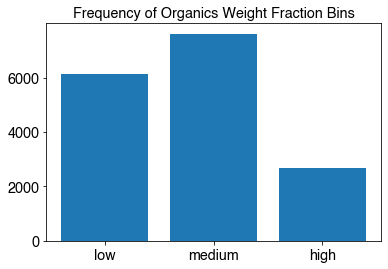

Label bin:  [0 1 2]
Count    :  [6127 7617 2695]
Frequency:  [0.37, 0.46, 0.16]


In [80]:
# View bar plot of WF bins
blt.bar_graph_bins(ybin, data_composition="Organics")

## Split data

In [81]:
# Split training data into training and test data (to be set aside)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, ybin, test_size=4110, random_state=1922, stratify=ybin
)
print([X_train.shape, X_test.shape])
print([y_train.shape, y_test.shape])

[(12329, 53), (4110, 53)]
[(12329,), (4110,)]


In [82]:
# Set aside "source" data
from sklearn.model_selection import train_test_split

X_train, X_source, y_train, y_source = train_test_split(
    X_train, y_train, train_size=100, random_state=1922, stratify=y_train
)
print([X_train.shape, X_source.shape])
print([y_train.shape, y_source.shape])

[(100, 53), (12229, 53)]
[(100,), (12229,)]


## Pre-check PCA

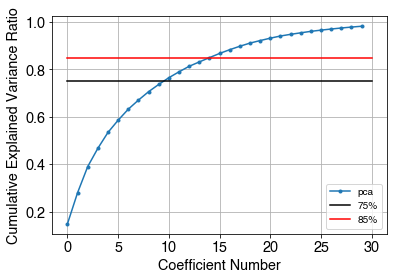

In [97]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition

# Scale the data first (i.e., chemical properties) from 0 to 1
scaler = MinMaxScaler()
X_source_scaled = scaler.fit_transform(X_source)

# Figure out number of components to achieve 85% cumulative explained variance
pca = decomposition.PCA(n_components=30)
pca.fit(X_source_scaled)

fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), ".-", label="pca")
plt.plot([0, 30], [0.75, 0.75], "k", label="75%")
plt.plot([0, 30], [0.85, 0.85], "r", label="85%")
plt.xlabel("Coefficient Number")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid()
plt.legend()
plt.show()

# Model optimization

In [83]:
import random as pyrandom
from numpy import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler

# Define feature mask for data augmentation
feat_names = X_source.columns
col_mask = ["cprp" not in name for name in feat_names]

# Function to add samples to training data


def random_augment(k, X_source, y_source, random_state, X, y):
    """Randomly samples source data to pair with target data."""

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Number of samples to select
    n_samples = k * len(X)
    # Obtain indices for randomly sampling source data
    idx_match = np.random.choice(len(X_source), n_samples)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    assert (
        X_aug.shape[0] == y_aug.shape[0]
    ), f"X_aug.shape={X_aug.shape}, y_aug.shape={y_aug.shape}"

    return X_aug, y_aug


def unsupervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Unsupervised data augmentation
    
    Match "k" most similar source data samples to target data samples 
    based on the smallest cosine distance between target and source data 
    samples (i.e., in an supervised fashion).
    """

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Cosine distance matrix using feature mask
    cosdist_samples = cosine_distances(X_source * col_mask, X * col_mask)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in cosdist_samples.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))

    return X_aug, y_aug

In [100]:
# Define models and parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt

random_state = 1922
augmentation_kwargs = {
    "augmentation_random_state": random_state,
    "augmentation_X_source": X_source,
    "augmentation_y_source": y_source,
}

models = {
    "RandomForestClassifier": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                RandomForestClassifier(
                    class_weight="balanced", random_state=random_state
                ),
            ),
        ],
        **augmentation_kwargs
    ),
    "SVC": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",  # balance by class size
                    random_state=random_state,
                ),
            ),
        ],
        **augmentation_kwargs
    ),
}
params = {
    "RandomForestClassifier": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],
        "dimreducer__n_components": [10, 11, 12, 13, 14],
        "estimator__max_depth": np.arange(2, 15, 2),
    },
    "SVC": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],
        "dimreducer__n_components": [10, 12, 14],
        "estimator__C": np.logspace(-1, 7, 5),
        "estimator__gamma": np.logspace(-7, 1, 5),
    },
}

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

# Apply gridsearch for optimal parameters
helper = blt.EstimatorSelectionHelper(models, params)
helper.fit(
    X_train, y_train, n_jobs=1, cv=5, scoring="balanced_accuracy",
)
results = helper.score_summary(sort_by="mean_score")
results.columns = [col.split("__")[-1] for col in results.columns]
results.infer_objects()

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 51.6min finished


RandomForestClassifier
SVC


,estimator,min_score,mean_score,max_score,std_score,augmentation_k,augmentation_type,n_components,max_depth,C,gamma
256,RandomForestClassifier,0.457672,0.707593,0.841270,0.133323,20,<function random_augment at 0x11d0f2ae8>,11,10.0,NaN,NaN
263,RandomForestClassifier,0.457672,0.697328,0.804762,0.126307,20,<function random_augment at 0x11d0f2ae8>,12,10.0,NaN,NaN
272,RandomForestClassifier,0.505291,0.697328,0.804762,0.102279,20,<function random_augment at 0x11d0f2ae8>,13,14.0,NaN,NaN
248,RandomForestClassifier,0.531746,0.693968,0.841270,0.123206,20,<function random_augment at 0x11d0f2ae8>,10,8.0,NaN,NaN
255,RandomForestClassifier,0.457672,0.693042,0.841270,0.137498,20,<function random_augment at 0x11d0f2ae8>,11,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
856,SVC,0.333333,0.333333,0.333333,0.000000,20,<function random_augment at 0x11d0f2ae8>,14,NaN,0.1,1.000000e-05
857,SVC,0.333333,0.333333,0.333333,0.000000,20,<function random_augment at 0x11d0f2ae8>,14,NaN,0.1,1.000000e-03
860,SVC,0.333333,0.333333,0.333333,0.000000,20,<function random_augment at 0x11d0f2ae8>,14,NaN,10.0,1.000000e-07
861,SVC,0.333333,0.333333,0.333333,0.000000,20,<function random_augment at 0x11d0f2ae8>,14,NaN,10.0,1.000000e-05


In [69]:
#%run organicstrain.py
#results_prelim = blt.apply_model_opt(models, params, X_target=X_train, y_target=y_train, cust_folds=5, random_state=1922, n_jobs=2,)

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:   48.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 175 candidates, totalling 875 fits
RandomForestClassifier
SVC


[Parallel(n_jobs=1)]: Done 875 out of 875 | elapsed: 226.7min finished


In [70]:
results_prelim

,estimator,min_score,mean_score,max_score,std_score,augmentation_k,augmentation_type,max_depth,C,gamma
47,RandomForestClassifier,0.632103,0.679718,0.747676,0.039180,14,<function random_augment at 0x11d0f2510>,12.0,NaN,NaN
46,RandomForestClassifier,0.617944,0.675797,0.740584,0.043931,14,<function random_augment at 0x11d0f2510>,10.0,NaN,NaN
48,RandomForestClassifier,0.632103,0.674314,0.712726,0.031519,14,<function random_augment at 0x11d0f2510>,14.0,NaN,NaN
39,RandomForestClassifier,0.592834,0.664627,0.701562,0.043564,9,<function random_augment at 0x11d0f2510>,10.0,NaN,NaN
207,SVC,0.571114,0.662559,0.707363,0.048502,14,<function random_augment at 0x11d0f2510>,NaN,10.0,1.000000e-01
...,...,...,...,...,...,...,...,...,...,...
200,SVC,0.333333,0.333333,0.333333,0.000000,14,<function random_augment at 0x11d0f2510>,NaN,0.1,1.000000e-05
201,SVC,0.333333,0.333333,0.333333,0.000000,14,<function random_augment at 0x11d0f2510>,NaN,0.1,1.000000e-03
204,SVC,0.333333,0.333333,0.333333,0.000000,14,<function random_augment at 0x11d0f2510>,NaN,10.0,1.000000e-07
205,SVC,0.333333,0.333333,0.333333,0.000000,14,<function random_augment at 0x11d0f2510>,NaN,10.0,1.000000e-05


In [2]:
#%run organicstrain.py
results_prelim = blt.apply_model_opt(
    models, params, X_target=X_train, y_target=y_train, cust_folds=5
)

Figure directory exists.
Figure directory exists.
X shape: (16439, 35)
y shape: (16439, 1)
[(8220, 35), (8219, 35)]
[(8220,), (8219,)]
[(4110, 35), (4110, 35)]
[(4110,), (4110,)]
Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   25.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 840 out of 840 | elapsed:  5.4min finished


Running GridSearchCV for SVC.
Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  6.7min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 22.7min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 92.4min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 238.9min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 657.5min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 1604.7min
[Parallel(n_jobs=8)]: Done 3000 out of 3000 | elapsed: 4069.5min finished


RandomForestClassifier
SVC


In [15]:
results_prelim

,estimator,min_score,mean_score,max_score,std_score,augmentation_k,augmentation_type,max_depth,C,gamma
0,RandomForestClassifier,0.673791,0.701755,0.735455,0.022357,15,<function random_augment at 0x00000112D0925DC8>,10.0,NaN,NaN
1,RandomForestClassifier,0.677211,0.701409,0.727961,0.018761,10,<function random_augment at 0x00000112D0925DC8>,10.0,NaN,NaN
2,RandomForestClassifier,0.673303,0.700497,0.727118,0.021046,5,<function random_augment at 0x00000112D0925DC8>,10.0,NaN,NaN
3,RandomForestClassifier,0.673362,0.700105,0.726929,0.022047,4,<function random_augment at 0x00000112D0925DC8>,10.0,NaN,NaN
4,RandomForestClassifier,0.662822,0.699138,0.727371,0.024271,10,<function random_augment at 0x00000112D0925DC8>,12.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
763,SVC,0.333333,0.333333,0.333333,0.000000,15,<function unsupervised_augment at 0x00000112D0...,NaN,0.1,1.000000e-05
764,SVC,0.333333,0.333333,0.333333,0.000000,15,<function unsupervised_augment at 0x00000112D0...,NaN,10.0,1.000000e-07
765,SVC,0.333333,0.333333,0.333333,0.000000,15,<function supervised_augment at 0x00000112BD62...,NaN,0.1,1.000000e-07
766,SVC,0.333333,0.333333,0.333333,0.000000,15,<function supervised_augment at 0x00000112BD62...,NaN,0.1,1.000000e-05


In [102]:
# Export preliminary results table to .csv
results.to_csv(
    "./data/results-prelim-organics.csv",
    sep="\t",
    header="infer",
    na_rep="NaN",
    index=False,
)

# Model evaluation

## SVC-RBF

In [ ]:
def run_hyperparams(df, random_state):
    """Apply hyperparameters for model evaluation."""

    # Select for highest performing parameters (averaged across 10 folds)
    df["augmentation_type"] = [
        str(i).split(" ")[1] for i in df.loc[:, "augmentation_type"]
    ]
    feat_subset = ["estimator", "augmentation_k", "augmentation_type"]
    df = df.drop_duplicates(subset=feat_subset, keep="first")
    df = df.sort_values(by=feat_subset, ascending=[False, True, True])
    df.columns = [col.split("__")[-1] for col in df.columns]
    df = df.reset_index(drop=True)

    # Placeholder lists for output
    df["score"] = np.nan
    df["score"] = df["score"].astype(object)
    
    # Only random_augment is useful here; drop other augmentation types
    df = df[df['augmentation_type'] == "random_augment"]

    for row in df.index:
        # Dictionary of classifier parameters, dropping nans
        cls_kwargs = df.iloc[row, -7:-4].dropna().to_dict()
        # Classifier function using dict
        if df.loc[row, "estimator"] == "SVC":
            classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
        else:
            classifier = RandomForestClassifier(class_weight="balanced", **cls_kwargs)
        # Make sure augmentation_type is a function
        augmentation_type = df.augmentation_type[row]
        dispatcher = {
            "random_augment": random_augment,
            "unsupervised_augment": unsupervised_augment,
            "supervised_augment": supervised_augment,
        }
        if isinstance(augmentation_type, str):
            augmentation_type = dispatcher[augmentation_type]
        # Only want random augmentation here
        if df.augmentation_type[row] is not random_augment:
            continue
        
        # Name figures using concatenated strings
        save_fig_name = "_".join(map(str, list(df.loc[row, feat_subset])))

        # Make parameter dict
        params = {
            "classifier": classifier,
            "augmentation_type": augmentation_type,
            "augmentation_k": df.augmentation_k[row],
            "random_state": random_state,
            "cust_folds": cust_folds,
            "save_fig_name": save_fig_name,
            "show_feat_impt": show_feat_impt,
        }
        score = model_eval(**params)
        df.score[row] = score
    cols_report = [
        "estimator",
        "augmentation_type",
        "augmentation_k",
        "score",
    ]

    return df[cols_report]

In [ ]:
# @notify_on_complete # play sound at completion
def model_eval(
    classifier,
    augmentation_type,
    augmentation_k,
    X=X_train,
    y=bin_enm,
    X_source=X_source,
    y_source=y_source,
    random_state=np.arange(30),
    cust_folds=None,
    save_fig_name=None,
    show_feat_impt=True,
    show_conf_matrix=True,
):
    """Fit execute and evaluate a classifier using hyperparameters.
    
    1) Fit custom model pipeline that performs data augmentation and 
    normalization on training data using optimized parameters and 
    stratified k-fold cross validation;
    3) Execute optimized model and summarize its accuracy in a confusion 
    matrix broken down by WF bins. Formatted confusion matrices are saved as 
    .pdf files.
    
    Arguments
    ---------
    classifier : function
    augmentation_type : function
    k : int
        The number of organics samples to match with each ENM sample.
    X : DataFrame (default=X_enm)
        Target feature data.
    y : ndarray (default=bin_enm)
        Target WF bin data
    X_source : DataFrame (default=X_enm)
        Source feature data.
    y_source : ndarray (default=bin_enm)
        Source WF bin data.
    random_state : ndarray (default=np.arange(30))
        Option to set the seed for CV.
    save_fig_name : string (default=None)
        A unique string used at the end of confusion matrix and feature 
        importance (rfc-only) file names for exporting the figures as .pdf; 
        `None` indicates that no figures should be saved
    show_feat_impt : bool (default=False)
        Only applicable when classifier is 'rfc'; `True` takes results from 
        an rfc as input to plot a bar graph of feature importance.
    show_cnf_matrix : bool (default=False)
        `True` results in matrix graphics being printed as output
    """
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import StratifiedKFold
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import confusion_matrix, balanced_accuracy_score
    import matplotlib.pyplot as plt

    def standard_error(bal_accu):
        """Calculate standard error from an array of balanced accuracies."""
        n = bal_accu.size
        samp_var = np.var(bal_accu, ddof=1)
        return np.sqrt(samp_var / n)

    feat_names = X.columns.values
    X = np.array(X)
    n_b = len(np.unique(y))  # Check number of bins

    # Set smallest class size as number of CV folds for leave-one-out CV
    _, class_counts = np.unique(y, return_counts=True)
    n_folds = min(class_counts)
    # Custom folds override
    if cust_folds:
        n_folds = cust_folds
    else:
        n_folds = n_folds

    augmentation_kwargs = {
        "augmentation_X_source": X_source,
        "augmentation_y_source": y_source,
        "augmentation_type": augmentation_type,
        "augmentation_k": augmentation_k,
    }

    # Placeholders for confusion matrix (cm), feature importance
    cm_cum_state = np.zeros([n_b, n_b])
    arr_norm_state_avg = []
    std_err = []
    impt_cum = np.zeros(len(feat_names))

    for state in random_state:
        # CV settings
        skfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=state)
        # Placeholders
        arr_cm_norm_fold = np.zeros([n_folds, n_b, n_b])
        arr_norm_fold_avg = []
        impt_state = np.zeros(len(feat_names))

        # Fit and run pipeline
        for i, (train_index, test_index) in enumerate(skfold.split(X, y)):
            # Split data
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]
            # Pipeline with data augmentation
            pipe = AugmentingPipeline(
                [
                    ("scale", MinMaxScaler()),
                    ("estimator", classifier.set_params(random_state=state)),
                ],
                **augmentation_kwargs
            )
            pipe.fit(X_train, y_train)

            # Optional calculate feature importance (RFC only)
            if show_feat_impt:
                importances = classifier.feature_importances_
                impt_state += importances

            # Write prediction results to confusion matrix
            cm_fold = np.zeros([n_b, n_b])
            cm_fold = confusion_matrix(y_test, pipe.predict(X_test))  # size 3x3
            # Normalize balanced accuracy
            arr_cm_norm_fold[i, :, :] = (
                cm_fold.astype("float") / cm_fold.sum(axis=1)[:, np.newaxis]
            )  # 10x3x3
            # Get balanced average proportion of correct classifications
            arr_norm_fold_avg.append(
                arr_cm_norm_fold[i, :, :].diagonal().mean()
            )  # size 10

        # Accumulate data for each fold (n_fold total) over 30 trials
        cm_cum_state += np.average(arr_cm_norm_fold, axis=0)  # size 3x3
        arr_norm_state_avg.append(np.average(arr_norm_fold_avg))  # size 30
        std_err.append(standard_error(bal_accu=np.array(arr_norm_fold_avg)))  # size 30
        if show_feat_impt:
            impt_cum += impt_state

    # Average over 30 trials
    cm_avg_all = cm_cum_state / len(random_state)  # size 3x3
    std_err_avg = np.average(np.array(std_err))
    impt_avg = np.asarray(
        [i / (len(random_state) * n_folds) for i in impt_cum], dtype=np.float64,
    )
    # Average normalized balanced accuracy overall
    bal_accu_avg = cm_avg_all.diagonal().mean()

    # Plot and save normalized confusion matrix, optional feature importance
    fig = plt.figure()
    plot_conf_matrix(cm_avg_all, classes=["low", "mid", "high"])
    if np.all(save_fig_name != None):
        savepdf(fig, "confusion_norm_%s" % save_fig_name)
    if not show_conf_matrix:
        plt.close(fig)
    if show_feat_impt:
        plot_feat_impt(
            feat_names,
            impt_avg,
            variances=None,
            save_fig_name=save_fig_name,
            combo_impt=False,
        )

    # Set output based on chosen classifier
    if show_feat_impt:
        return arr_norm_state_avg, std_err, impt_avg
    else:
        return arr_norm_state_avg, std_err

In [ ]:
# SVC
results_svc = blt.run_hyperparams(
    results_prelim[results_prelim["estimator"] == "SVC"].astype(object),
    cust_folds=5,
    random_state=np.arange(30),
    show_feat_impt=False,
)

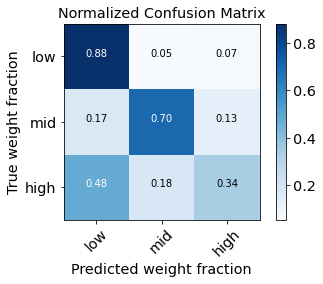

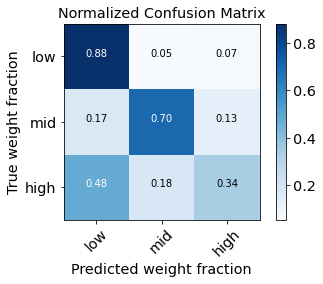

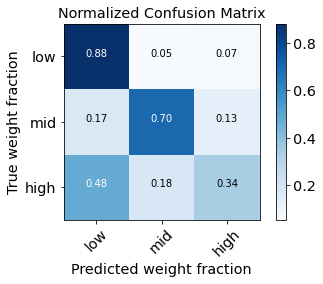

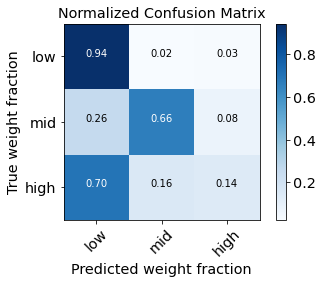

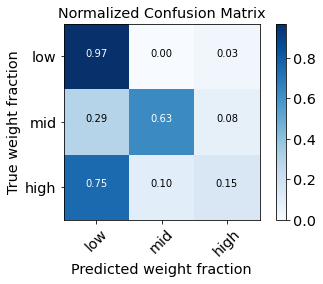

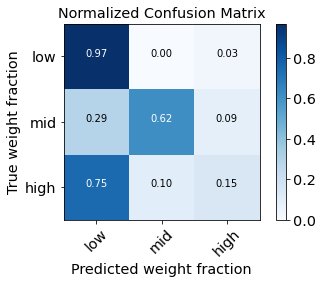

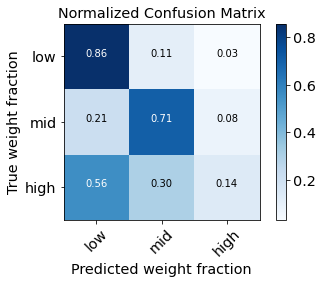

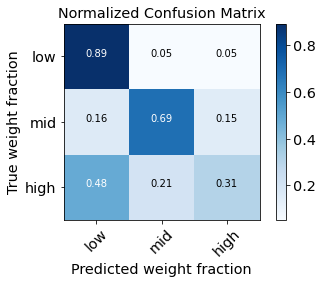

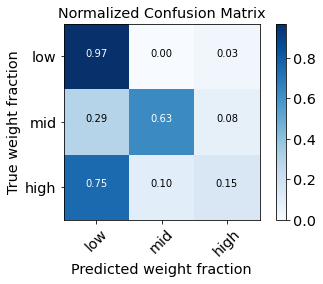

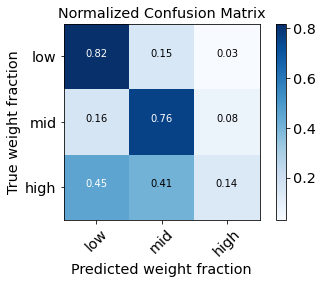

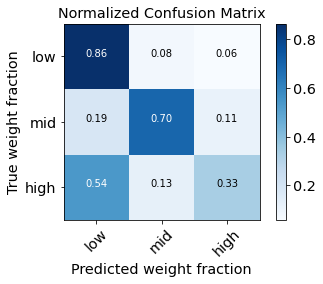

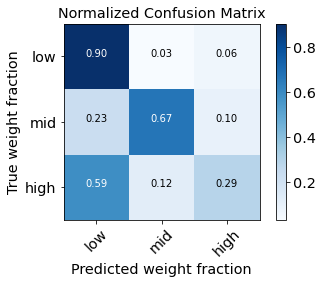

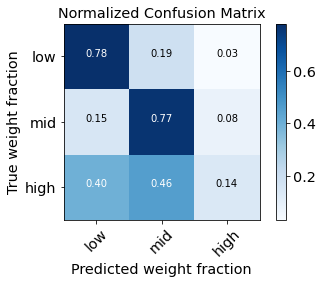

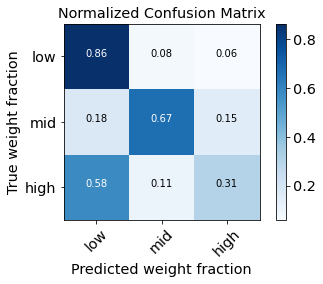

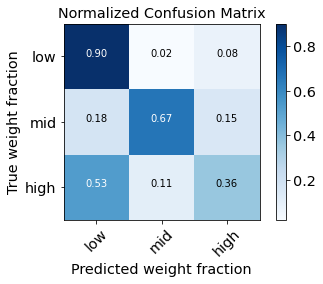

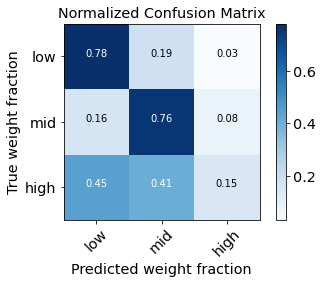

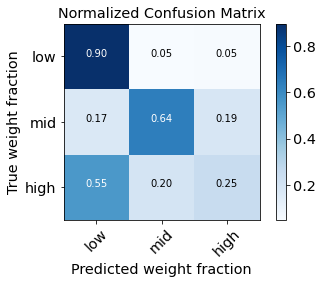

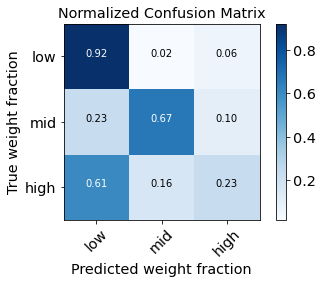

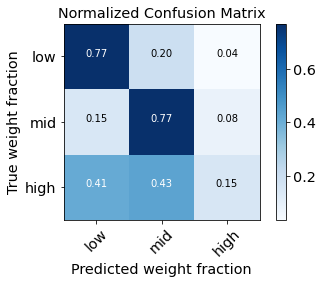

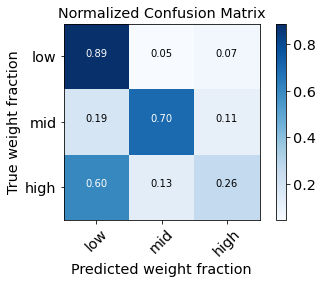

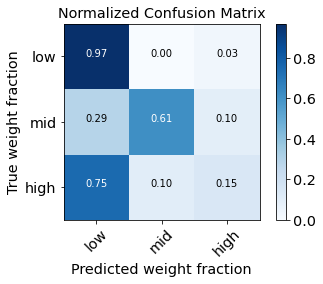

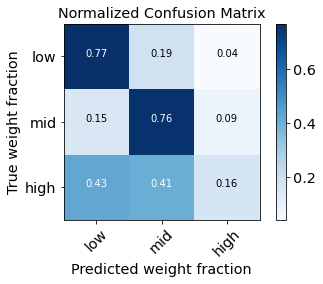

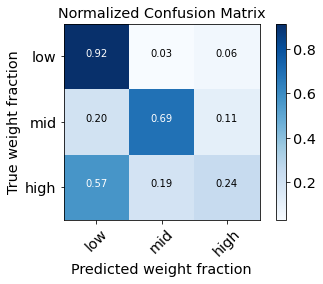

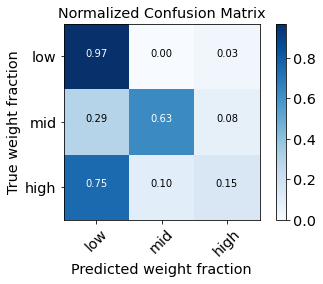

In [16]:
# SVC
results_svc = blt.run_hyperparams(
    results_prelim[results_prelim["estimator"] == "SVC"].astype(object),
    cust_folds=5,
    random_state=np.arange(30),
    show_feat_impt=False,
)

## RFC

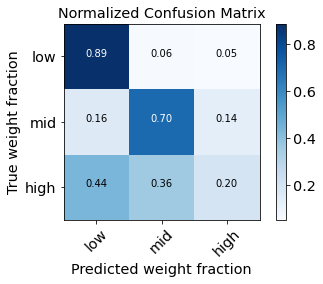

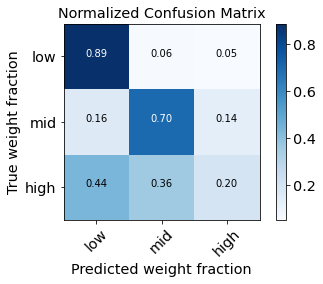

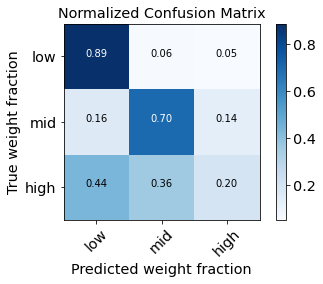

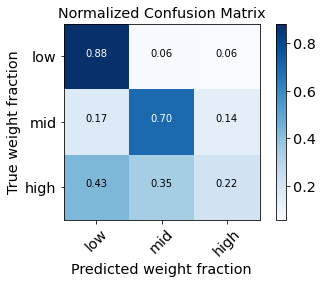

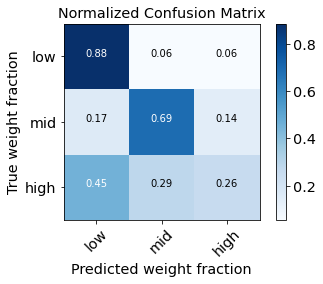

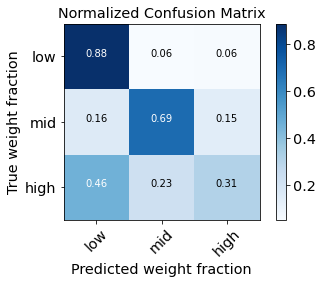

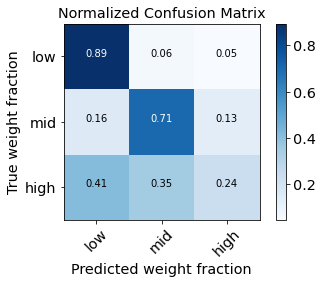

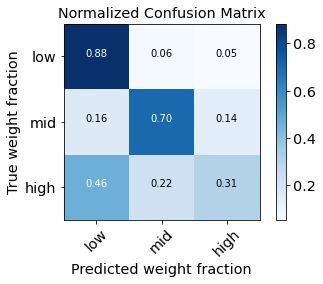

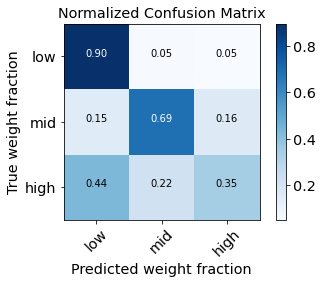

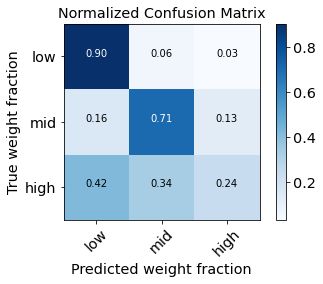

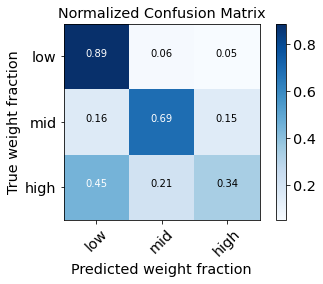

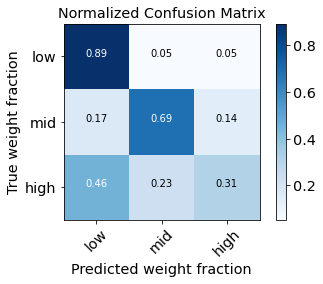

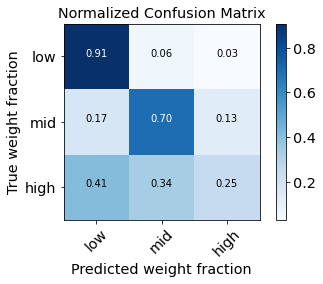

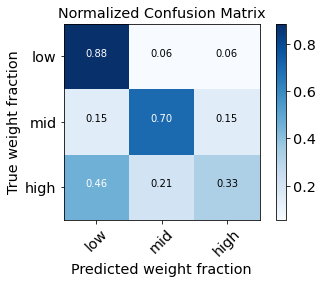

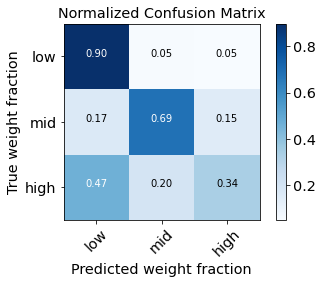

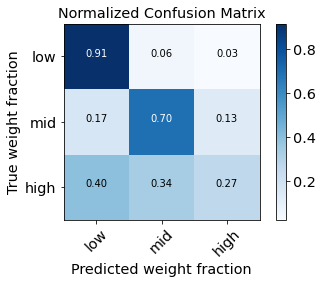

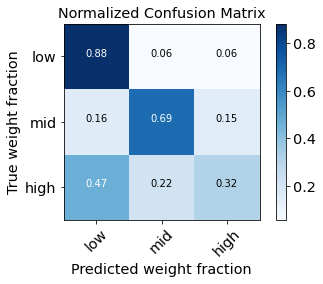

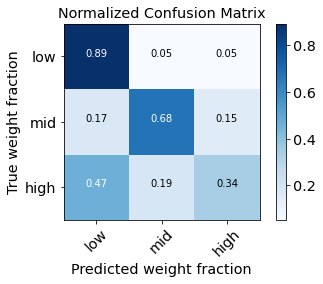

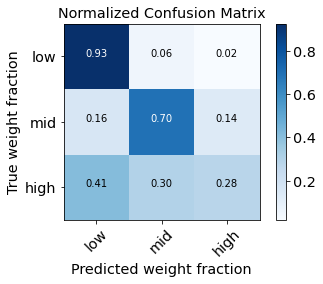

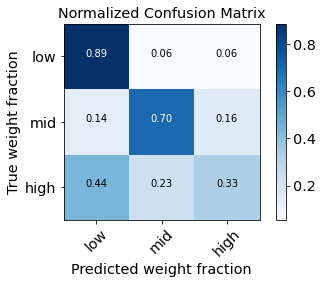

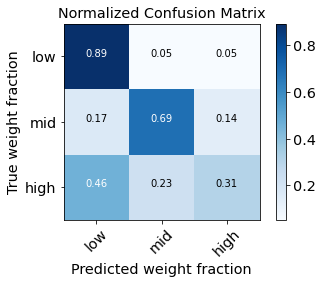

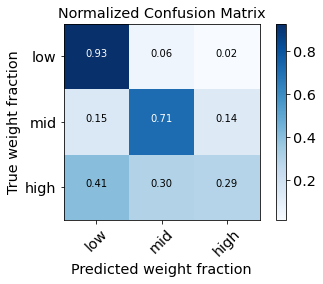

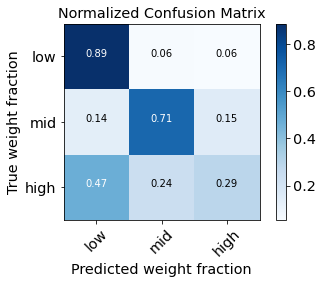

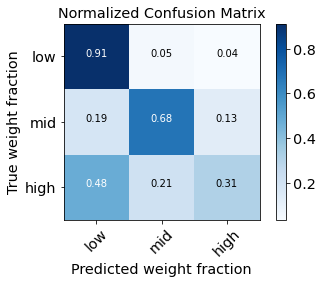

In [17]:
# RFC
results_rfc = blt.run_hyperparams(
    results_prelim[results_prelim["estimator"] == "RandomForestClassifier"],
    cust_folds=5,
    random_state=np.arange(30),
    show_feat_impt=False,
)

# Performance results

Note that data augmentation was not performed on data frames only containing ENM data (non-permuted and permuted).

In [18]:
def display_table(df, df2=None):
    """Redisplay results as table for publication."""

    if isinstance(df2, pd.DataFrame):
        df = pd.concat([df, df2])

    # Tidy up labels, decimal places
    df["augmentation_type"] = df["augmentation_type"].str.title()
    df["augmentation_type"] = df["augmentation_type"].str.replace("_", "")
    df["estimator"] = df["estimator"].str.replace("RandomForestClassifier", "RFC")
    df["std_err_avg"] = [np.average(i) for i in df["std_err"]]
    pd.set_option("display.precision", 3)

    # Pivot table
    table = df.pivot(
        index=["augmentation_k", "augmentation_type"],
        columns="estimator",
        values="score",
    )

    return table

In [19]:
table_all = display_table(results_svc, results_rfc)
table_all

estimator                             RFC    SVC
augmentation_k augmentation_type                
0              RandomAugment        0.596  0.639
               SupervisedAugment    0.596  0.639
               UnsupervisedAugment  0.596  0.639
1              RandomAugment        0.599  0.583
               SupervisedAugment    0.611  0.581
               UnsupervisedAugment   0.63  0.578
2              RandomAugment        0.614  0.568
               SupervisedAugment    0.631   0.63
               UnsupervisedAugment  0.646  0.581
3              RandomAugment        0.617  0.571
               SupervisedAugment    0.639  0.632
               UnsupervisedAugment  0.631  0.621
4              RandomAugment        0.618  0.563
               SupervisedAugment    0.636  0.615
               UnsupervisedAugment   0.64  0.643
5              RandomAugment        0.627  0.563
               SupervisedAugment    0.631  0.594
               UnsupervisedAugment  0.637  0.606
10             RandomAugment        0.636  0.563
               SupervisedAugment    0.639  0.616
               UnsupervisedAugment  0.631  0.576
15             RandomAugment        0.643  0.564
               SupervisedAugment    0.629  0.617
               UnsupervisedAugment  0.635  0.581

In [20]:
def line_plot(df, errors=None, save_fig_name=None):

    if isinstance(errors, pd.DataFrame):
        errors = errors.unstack(level=[1])
    pltstyle = [":", ":", ":", "-", "-", "-"]
    pltcolor = ["tab:olive", "royalblue", "navy"]
    myplot = df.unstack(level=[1]).plot(
        kind="line", subplots=False, style=pltstyle, color=pltcolor, yerr=errors
    )
    plt.title("Performance of Classification Models", pad=10)
    plt.xlabel("Augmentation $k$")
    plt.ylabel("Average Balanced Accuracy")
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.gca().legend(loc="lower center", bbox_to_anchor=(0.5, -0.45), ncol=2)
    if save_fig_name:
        fig = myplot.get_figure()
        blt.savepdf(fig, save_fig_name)

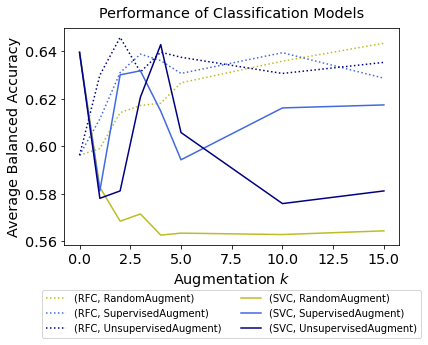

In [21]:
line_plot(df=table_all, errors=None, save_fig_name="bal-accu-plot-organics")

In [22]:
# Export preliminary results table to .csv
table_all.to_csv(
    "./data/results-final-organics.csv",
    sep="\t",
    header="infer",
    na_rep="NaN",
    index=False,
)

## Significance testing

In [ ]:
# Test for significance of paired difference between model distributions
"""
The Wilcoxon signed-rank test is a non-parametric version of the paired T-test.
https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.stats.wilcoxon.html
"""
from scipy.stats import wilcoxon
wilcoxon(x=base_distrib, y=match_distrib) # alternative='two-sided' # alternative='less'

Our null hypothesis was that the balanced average for our baseline model was the same as that of the best model. The alternative hypothesis is that the baseline model is smaller than the best model. Because the p-value (divided by 2 for a one-tailed test) from the Wilcoxon signed-rank test was incredibly small in comparison to an alpha of 0.05, we can reject the null hypothesis. It is statistically likely that the best model performs better than the baseline.

In [ ]:
# Test for significance of paired difference using different feature groups
distrib_base = [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7]
distrib_noWF = [0.73, 0.7, 0.73, 0.7, 0.7, 0.72, 0.71, 0.7, 0.71, 0.71, 0.72, 0.71, 0.71, 0.72, 0.72, 0.71, 0.73, 0.72, 0.7, 0.72, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.71, 0.72, 0.7]
distrib_noPM = [0.64, 0.62, 0.63, 0.63, 0.63, 0.63, 0.62, 0.63, 0.64, 0.62, 0.62, 0.62, 0.61, 0.62, 0.63, 0.62, 0.65, 0.61, 0.62, 0.62, 0.62, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64]
distrib_unsup1to10 = [0.75, 0.75, 0.75, 0.75, 0.74, 0.75, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.74, 0.75, 0.75, 0.75, 0.75, 0.77, 0.75, 0.75, 0.75, 0.74, 0.76, 0.76, 0.74, 0.75, 0.74, 0.75, 0.75, 0.74]

In [ ]:
# Baseline vs no was_WF_measured
from scipy.stats import wilcoxon
wilcoxon(x=distrib_base, y=distrib_noWF) # alternative='two-sided' # alternative='less'

In [ ]:
# Baseline vs no PUCs, matrix properties
wilcoxon(x=distrib_base, y=distrib_noPM) 

In [ ]:
# Baseline vs unsupervised matching augmentation 1:10 ratio
wilcoxon(x=distrib_base, y=distrib_unsup1to10) 